In [1]:
import json
import pandas as pd
today = "2018-12-27"

In [2]:
import json
def read_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

today = "2018-12-27"

# list of arrays for each model.
cv_results = {alg: read_json(f"out/{today}/{today}-{alg}-cv_results.json") for alg in ["hyperband", "hyperband-w-patience", "patience"]}

# list of arrays with each score/time/etc. Each model entered more than once.
histories = {alg: read_json(f"out/{today}/{today}-{alg}-history.json")for alg in ["hyperband", "hyperband-w-patience", "patience"]}

In [3]:
data = histories["hyperband"]
df = pd.DataFrame(data)
df.head()

,bracket,elapsed_wall_time,estimator_id,params,partial_fit_calls,partial_fit_time,score,score_time
0,2,33.247946,bracket=2-0,"{'train_split': None, 'optimizer__weight_decay...",1,6.191988,-0.168343,1.380640
1,2,33.247949,bracket=2-1,"{'train_split': None, 'optimizer__weight_decay...",1,5.980162,-0.260585,1.384703
2,2,33.247963,bracket=2-2,"{'train_split': None, 'optimizer__weight_decay...",1,2.764691,-0.228833,2.475700
3,2,33.247964,bracket=2-3,"{'train_split': None, 'optimizer__weight_decay...",1,6.519136,-0.160083,1.341483
4,2,33.247966,bracket=2-4,"{'train_split': None, 'optimizer__weight_decay...",1,6.244545,-0.266085,1.263151


This is too many

In [4]:
calls = 243
chunks = 3
epochs = calls / chunks
epochs

81.0

In [5]:
243 / 4

60.75

['bracket=0-0',
 'bracket=0-1',
 'bracket=0-2',
 'bracket=0-3',
 'bracket=0-4',
 'bracket=1-0',
 'bracket=1-2',
 'bracket=2-8',
 'bracket=3-0',
 'bracket=4-45']


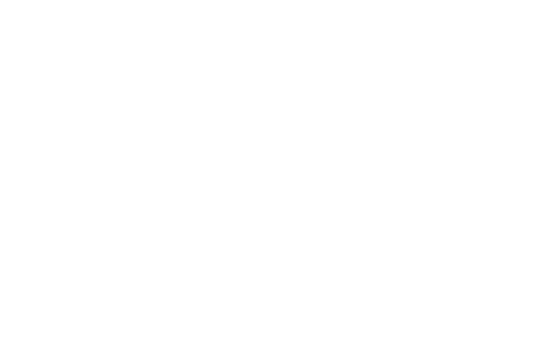

In [63]:
import altair as alt

df = pd.DataFrame(histories["hyperband-w-patience"])
# df = pd.DataFrame(histories["hyperband"])

show = df

to_keep = [k["estimator_id"]
           for _, k in show.iterrows()
           if np.abs(k["partial_fit_calls"] - show.partial_fit_calls.max()) < 20]
from pprint import pprint
pprint(list(sorted(to_keep)))

i = np.array([df.estimator_id == k for k in to_keep])
i = i.sum(axis=0).astype(bool)
show = show[i]
show = show[-0.11 < show.score]
alt.Chart(show).mark_line(point=True).encode(
    x="partial_fit_calls",
    y=alt.Y("score", scale=alt.Scale(zero=False)),
#     column="bracket",
    color="estimator_id",
)

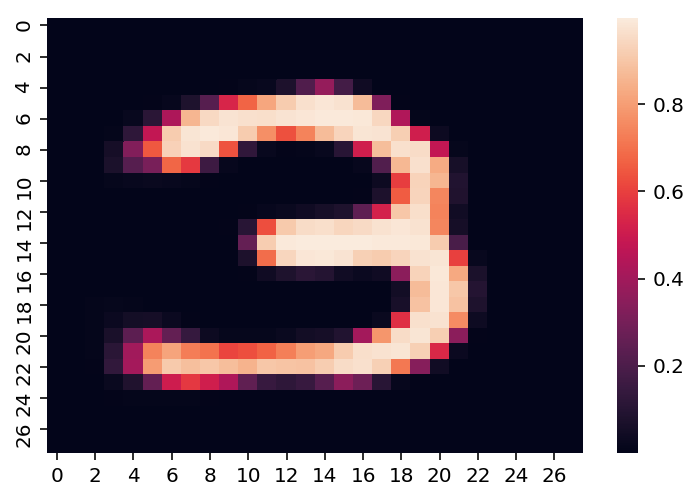

In [3]:
import numpy as np
data = np.load(f"out/{today}/{today}-hyperband-test.npz")
y_hat = data["y_hat"]

import seaborn as sns
sns.heatmap(y_hat[0].reshape(28, 28))

## Performance
`HyperbandCV` will find close to the best possible parameters with the given computational budget.*

<sup>* "will" := with high probability,
"close" := within log factors,
"best possible" in expected value.</sup>


In [4]:
len(cv_results["hyperband"]["estimator_id"])

143

In [5]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["estimator_id"]] = row["score"]
        pf_calls[row["estimator_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [6]:
from copy import copy, deepcopy
def smooth_histories(hist_list):
    out = []
    data = {}
    hist_list = deepcopy(hist_list)
    times = sorted([h["elapsed_wall_time"] for hist in hist_list for h in hist])
    
    hists = {repeat: hist for repeat, hist in enumerate(hist_list)}
    for t in times:
        for k, hist in hists.items():
            h = deepcopy(hists[k][0])
            h.update({"elapsed_wall_time": t})
            out += [h]
            
            if hists[k][0]["elapsed_wall_time"] >= t and len(hists[k]) > 1:
                hists[k].pop(0)
    return out

In [7]:
medium_rare = [shape_history(hist, repeat=0, alg=k)
               for k, hist in histories.items()]
# medium = [smooth_histories(hist) for hist in medium_rare]

well_done = sum(medium_rare, [])

In [8]:
import pandas as pd
df = pd.DataFrame(well_done)
df.head(n=2)
df.elapsed_wall_time.describe()
print(df.alg.unique())
df.head()

['hyperband' 'hyperband-w-patience' 'patience']


,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,repeat
0,hyperband,-0.168343,1,0.000000,0
1,hyperband,-0.168343,2,0.000003,0
2,hyperband,-0.168343,3,0.000017,0
3,hyperband,-0.160083,4,0.000018,0
4,hyperband,-0.160083,5,0.000020,0


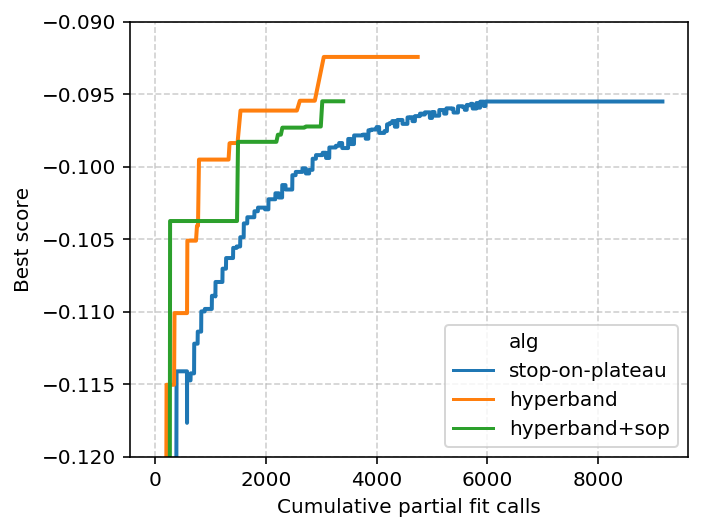

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use()

# adaptiveness = ["patience", "hyperband-w-patience", "hyperband"]
adaptiveness = ["stop-on-plateau", "hyperband", "hyperband+sop"]

show = df.copy()
idx = show.alg == "patience"
show.loc[idx, "alg"] = "stop-on-plateau"
idx = show.alg == "hyperband-w-patience"
show.loc[idx, "alg"] = "hyperband+sop"

# show["Passes through data"] = df["cumulative_partial_fit_calls"] / 3
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
#     palette="magma_r",
    linewidth=2,
    ax=ax,
)
ax.set_ylim(-0.12, -0.09)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Cumulative partial fit calls")
plt.savefig(f"{today}-cum-calls.svg", bbox_inches="tight")

In [10]:
# s = df[df.alg == "hyperband-w-patience"]

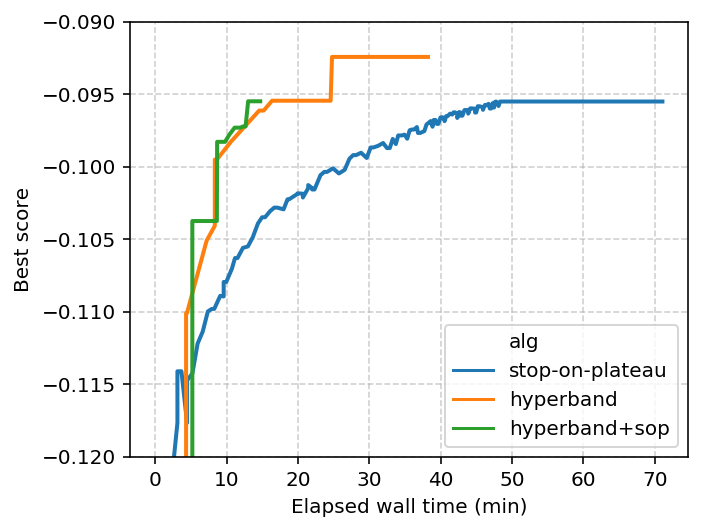

In [11]:
import seaborn as sns

# adaptiveness = ["patience", "hyperband", "hyperband-w-patience"]

# show = df.copy()
show["elapsed_wall_time (min)"] = show["elapsed_wall_time"] / 60

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.lineplot(
    data=show,
    x="elapsed_wall_time (min)",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
#     palette="magma_r",
    linewidth=2,
    ax=ax,
)
ax.set_ylim(-0.12, -0.09)
ax.grid(linestyle="--", alpha=0.6)
ax.set_ylabel("Best score")
ax.set_xlabel("Elapsed wall time (min)")
plt.savefig(f"{today}-wall-time.svg", bbox_inches="tight")

## Parameter visualization

In [11]:
# results = {k: [result[k] for result in cv_results["patience"]]
#               for k in cv_results["patience"][0]}
# results = {k: sum(v, []) for k, v in results.items()}

In [12]:
import numpy as np
hist = pd.DataFrame(cv_results[""])
hist.head()

#hist['param_optimizer_'] = hist['param_optimizer'].apply(lambda opt: str(opt).replace('<class', '').strip('>'))
hist['test_loss'] = -1 * hist['test_score']
hist = hist.sort_values(by='test_loss')
hist['rank'] = np.arange(len(hist)) + 1
hist.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,estimator_id,params,partial_fit_calls,param_train_split,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__lr,param_optimizer,param_module__init,param_module__activation,param_batch_size,rank_test_score,test_loss,rank
21,10.062847,3.350648,6.167028,1.211837,-0.095504,21,"{'train_split': None, 'optimizer__weight_decay...",114,None,0.000015,True,0.445445,1.785467,SGD,kaiming_uniform_,ELU,32,1,0.095504,1
55,10.036392,3.574998,6.173667,1.392172,-0.096077,55,"{'train_split': None, 'optimizer__weight_decay...",103,None,0.000012,True,0.120120,2.437176,SGD,kaiming_normal_,ELU,32,2,0.096077,2
11,7.491892,3.113025,4.607077,0.938731,-0.097805,11,"{'train_split': None, 'optimizer__weight_decay...",144,None,0.000021,True,0.113113,1.656606,SGD,kaiming_normal_,PReLU,64,3,0.097805,3
14,7.147917,3.040090,4.481596,1.072677,-0.098660,14,"{'train_split': None, 'optimizer__weight_decay...",181,None,0.000011,True,0.491491,0.129752,SGD,xavier_uniform_,PReLU,64,4,0.098660,4
10,3.876608,2.563282,2.288659,0.713975,-0.098836,10,"{'train_split': None, 'optimizer__weight_decay...",111,None,0.000027,True,0.646647,3.288645,SGD,xavier_normal_,PReLU,512,5,0.098836,5


64 estimators


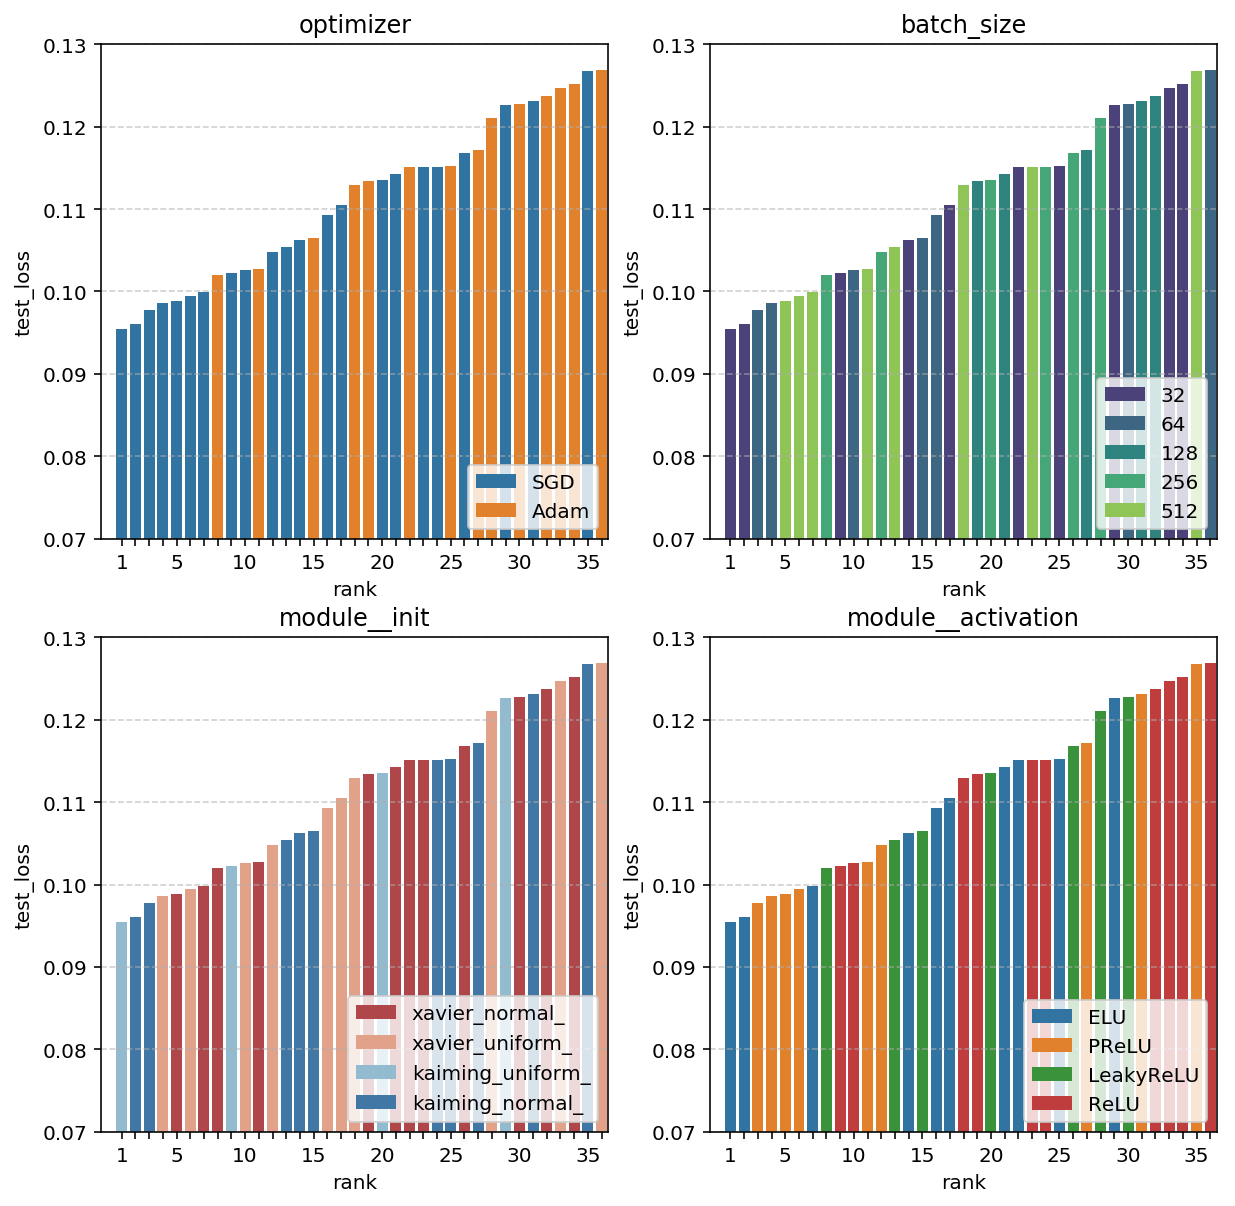

In [49]:
import matplotlib.ticker as ticker
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
hues = ['param_optimizer', 'param_batch_size', 'param_module__init', 'param_module__activation']
print("{} estimators".format(len(hist)))
for ax, hue in zip(axs, hues):
    cmap = None
    if 'batch_size' in hue:
        cmap = 'viridis'
    hue_order = None
    if "init" in hue:
        cmap = "RdBu"
        hue_order = ["xavier_normal_", "xavier_uniform_", "", "", "kaiming_uniform_", "kaiming_normal_"]
    sns.barplot(
        x='rank', 
        y='test_loss',
        hue=hue,
        hue_order=hue_order,
        data=hist,
        ax=ax,
        palette=cmap,
        dodge=False,
    )
    ax.set_xlim(-1.5, 64 - 29 + 0.5)
    ax.grid(linestyle='--', axis='y', alpha=0.6)
    ax.legend(loc='lower right')
    ax.set_title(hue.replace('param_', ''))
    xticklabels = ax.get_xticklabels()
    xticklabels = [x if int(x.get_text()) % 5 == 0 or int(x.get_text()) == 1 else plt.Text(1, 1, "") for x in xticklabels]
    ax.set_xticklabels(xticklabels)
    
    ax.set_ylim(0.07, 0.13)
plt.savefig("figs/ranks.png", bbox_inches="tight")
plt.show()

In [139]:
sgd_alg = [a for a in hist.param_optimizer.unique() if 'sgd' in a.lower()][0]
sgd = hist[hist.param_optimizer == sgd_alg]
sgd.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,estimator_id,params,partial_fit_calls,param_train_split,param_optimizer__weight_decay,param_optimizer__nesterov,param_optimizer__momentum,param_optimizer__lr,param_optimizer,param_module__init,param_module__activation,param_batch_size,rank_test_score,test_loss,rank
21,10.062847,3.350648,6.167028,1.211837,-0.095504,21,"{'train_split': None, 'optimizer__weight_decay...",114,None,0.000015,True,0.445445,1.785467,SGD,kaiming_uniform_,ELU,32,1,0.095504,1
55,10.036392,3.574998,6.173667,1.392172,-0.096077,55,"{'train_split': None, 'optimizer__weight_decay...",103,None,0.000012,True,0.120120,2.437176,SGD,kaiming_normal_,ELU,32,2,0.096077,2
11,7.491892,3.113025,4.607077,0.938731,-0.097805,11,"{'train_split': None, 'optimizer__weight_decay...",144,None,0.000021,True,0.113113,1.656606,SGD,kaiming_normal_,PReLU,64,3,0.097805,3
14,7.147917,3.040090,4.481596,1.072677,-0.098660,14,"{'train_split': None, 'optimizer__weight_decay...",181,None,0.000011,True,0.491491,0.129752,SGD,xavier_uniform_,PReLU,64,4,0.098660,4
10,3.876608,2.563282,2.288659,0.713975,-0.098836,10,"{'train_split': None, 'optimizer__weight_decay...",111,None,0.000027,True,0.646647,3.288645,SGD,xavier_normal_,PReLU,512,5,0.098836,5


['SGD']


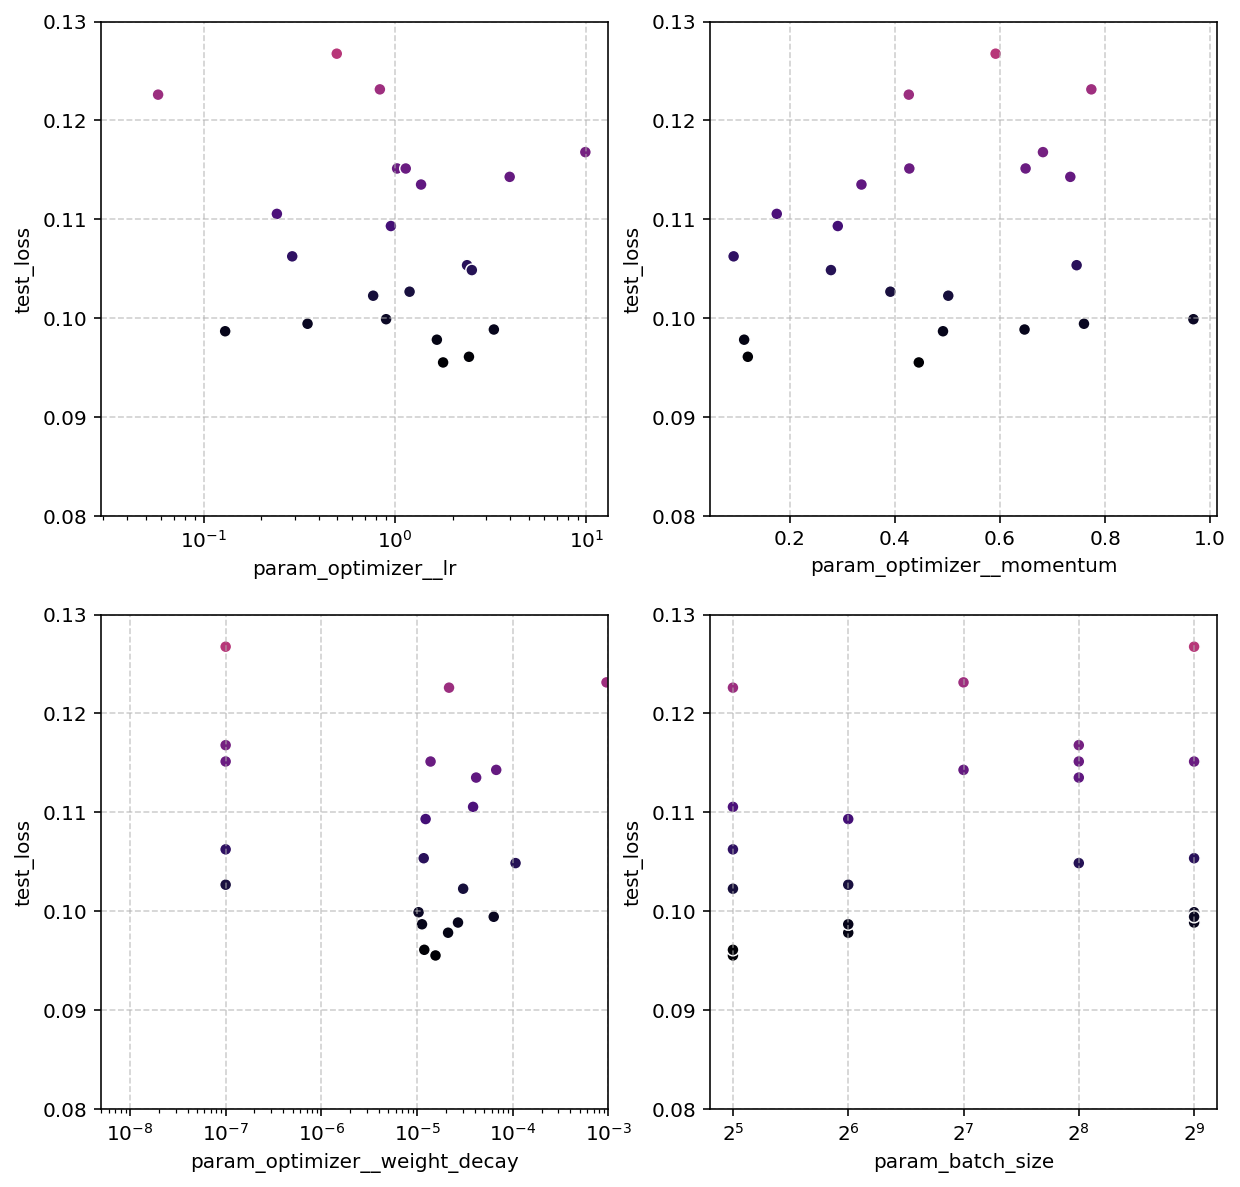

In [144]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
variables = ['param_optimizer__lr', 'param_optimizer__momentum', 'param_optimizer__weight_decay', 'param_batch_size']
print(sgd.param_optimizer.unique())
for ax, var in zip(axs, variables):
    show = sgd.copy()
    show = show.sort_values(by=var)
    if 'weight_decay' in var:
        show[var] += 1e-7
    show = show[show.test_loss < 0.16]
    sns.scatterplot(
        x=var,
        y='test_loss',
        data=show,
        hue='test_loss',
        palette='magma',
        legend=False,
        ax=ax,
    )
    if 'lr' in var:
        ax.set_xscale('log', basex=10)
    if 'batch_size' in var:
        ax.set_xscale('log', basex=2)
    if 'weight_decay' in var:
        ax.set_xlim(5e-9, 1e-3)
        ax.set_xscale('log', basex=10)
    
    ax.grid(linestyle='--', alpha=0.6)
    ax.set_ylim(0.08, 0.13)
plt.savefig("figs/sgd.png", bbox_inches="tight")
plt.show()

In [71]:
histories["hyperband-w-patience"][0]

{'estimator_id': 'bracket=2-0',
 'params': {'train_split': None,
  'optimizer__weight_decay': 1.0233165783302449e-05,
  'optimizer__nesterov': True,
  'optimizer__momentum': 0.996996996996997,
  'optimizer__lr': 2.596655972934871,
  'optimizer': 'SGD',
  'module__init': 'xavier_normal_',
  'module__activation': 'ReLU',
  'batch_size': 512},
 'partial_fit_calls': 1,
 'partial_fit_time': 2.245530128479004,
 'score': -0.2325514703989029,
 'score_time': 1.762643814086914,
 'elapsed_wall_time': 39.68138575553894,
 'bracket': 2}

In [95]:
import toolz


def get_number(l, **kwargs):
    pf_calls = toolz.groupby("partial_fit_calls", l)
    return [{"num_est": len(li), "pf_calls": k, **kwargs} for k, li in pf_calls.items()]

def calls_per_iteration(history, **kwargs):
    data = [
        {
            "est_id": int(h["estimator_id"].split("-")[-1]),
            "bracket": h["bracket"],
            "partial_fit_calls": h["partial_fit_calls"],

        }
        for h in history
    ]


    brackets = toolz.groupby("bracket", data)
    d = [get_number(l, bracket=k, **kwargs) for k, l in brackets.items()]
    d = sum(d, [])
    return d

In [104]:
data = calls_per_iteration(histories["hyperband"], alg="hyperband")
data += calls_per_iteration(histories["hyperband-w-patience"], alg="hyperband-w-patience")

In [105]:
data[:10]

[{'num_est': 15, 'pf_calls': 1, 'bracket': 2, 'alg': 'hyperband'},
 {'num_est': 15, 'pf_calls': 27, 'bracket': 2, 'alg': 'hyperband'},
 {'num_est': 5, 'pf_calls': 81, 'bracket': 2, 'alg': 'hyperband'},
 {'num_est': 1, 'pf_calls': 243, 'bracket': 2, 'alg': 'hyperband'},
 {'num_est': 8, 'pf_calls': 1, 'bracket': 1, 'alg': 'hyperband'},
 {'num_est': 8, 'pf_calls': 81, 'bracket': 1, 'alg': 'hyperband'},
 {'num_est': 2, 'pf_calls': 243, 'bracket': 1, 'alg': 'hyperband'},
 {'num_est': 5, 'pf_calls': 1, 'bracket': 0, 'alg': 'hyperband'},
 {'num_est': 5, 'pf_calls': 243, 'bracket': 0, 'alg': 'hyperband'},
 {'num_est': 34, 'pf_calls': 1, 'bracket': 3, 'alg': 'hyperband'}]

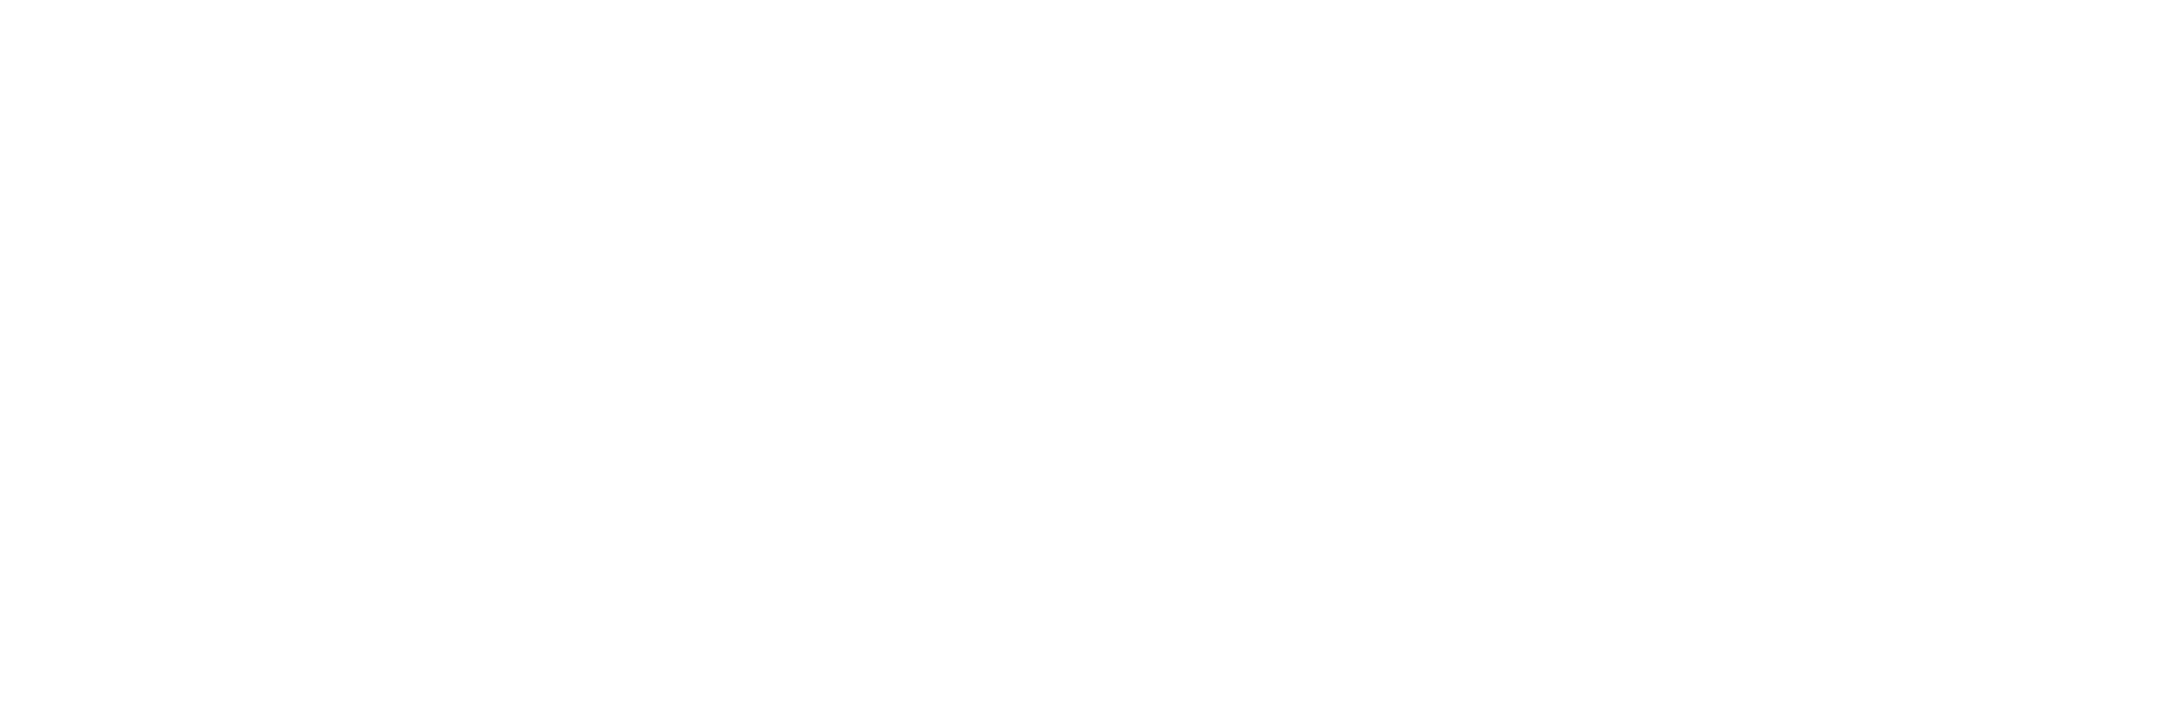

In [106]:
show = pd.DataFrame(data)
import altair as alt
alt.Chart(show).mark_bar().encode(
    x="pf_calls",
    y="num_est",
    column="bracket",
    row="alg",
)

In [123]:
from pprint import pprint
one = cv_results["hyperband"]["params"][0]
pprint(one)

d = [c for c in cv_results["hyperband-w-patience"]["params"]
 if c["batch_size"] == one["batch_size"]
 and c["module__init"] == one["module__init"]
 and c["module__activation"] == one["module__activation"]]
pprint(d) 

{'batch_size': 128,
 'module__activation': 'ELU',
 'module__init': 'kaiming_uniform_',
 'optimizer': 'SGD',
 'optimizer__lr': 0.03610418597173337,
 'optimizer__momentum': 0.2752752752752753,
 'optimizer__nesterov': True,
 'optimizer__weight_decay': 2.4682684522556925e-05,
 'train_split': None}
[{'batch_size': 128,
  'module__activation': 'ELU',
  'module__init': 'kaiming_uniform_',
  'optimizer': 'SGD',
  'optimizer__lr': 0.11041880508541607,
  'optimizer__momentum': 0.24924924924924924,
  'optimizer__nesterov': True,
  'optimizer__weight_decay': 0.00025084150592775414,
  'train_split': None},
 {'batch_size': 128,
  'module__activation': 'ELU',
  'module__init': 'kaiming_uniform_',
  'optimizer': 'SGD',
  'optimizer__lr': 6.379766808606282,
  'optimizer__momentum': 0.4444444444444444,
  'optimizer__nesterov': True,
  'optimizer__weight_decay': 3.686095362172162e-05,
  'train_split': None},
 {'batch_size': 128,
  'module__activation': 'ELU',
  'module__init': 'kaiming_uniform_',
  'opti